# Background: Solving Kirchhoof's law for transistors using load lines

In [1]:
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import matplotlib.ticker as plticker
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os
from scipy import optimize
import SchemDraw as schem
import SchemDraw.elements as e

ModuleNotFoundError: No module named 'SchemDraw'

In [2]:
def DivTensao(Z1, Z2, fonte = [True,e.SOURCE_V], unit_size = 2.5, **kwargs):
    d = schem.Drawing(unit=unit_size, **kwargs)
    if fonte[0]:
        #fonte
        gnd1 = d.add(e.GND)
        d.add(fonte[1], label='$V_{Th}$')
        d.add(e.RES, d='right', label='$R_g$')
    #divisor de tensão
    vin = d.add(e.DOT_OPEN ,label='$V_{in}$')
    z1 = d.add(Z1[0], d='right',label='${}$'.format(Z1[1]))
    z2 = d.add(Z2[0], d='down',botlabel='${}$'.format(Z2[1]))
    gnd2 = d.add(e.GND)
    #output
    d.add(e.LINE, d='right', xy=z1.end, l=1)
    vout = d.add(e.DOT_OPEN, label='$V_{out}$')
    #loop
    d.labelI(z2, '$I$',top=False, arrowofst = 0.8, arrowlen = 0.75)
    return d

This notebook implements functions to plot KVL solution using loadlines.

## Load-line solution of Kirchhoof's laws

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
def plot_load_lines(Vin=5,R1=100,R2=100):
    #limites dos eixos
    Vin_min, Vin_max = -6,6 # [V]
    I_min, I_max = -60,60 # [mA]
    #-------------
    I=np.linspace(I_min,I_max,100)
    #----------------------
    Vlhs = Vin-R1*I # equação LHS
    Vrhs = R2*I # equação RHS
    #---
    fig_size = (10,5)
    fig,ax = plt.subplots(1,2,figsize=fig_size)
    #------------------
    ax0 = ax[0]
    DivTensao([e.RES,'R_1'],[e.RES,'R_2'],fonte = [False,e.SOURCE_V]).draw(ax=ax0)
    ax0.axes.get_xaxis().set_visible(False)
    ax0.axes.get_yaxis().set_visible(False)
    ax0.set_frame_on(False)
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    ax0.get_figure().set_size_inches(fig_size[0],fig_size[1])
    #------------------
    ax0 = ax[1]
    ax0.plot(Vlhs,I*1e3, label = r'$V_{in}-R_1I-V(I)=0$')
    ax0.plot(Vrhs,I*1e3, label = r'$V(I)-R_2I=0$')
    #---
    #eixos x-y
    ax0.axhline(0, color='k', linestyle = '-',lw=2)
    ax0.axvline(0, color='k', linestyle = '-',lw=2)
    #---
    lab = '$V_{aberto}$'+'={} V'.format(Vin)
    ax0.scatter(Vin,0, color='b', marker='o', s=70, label=lab,zorder=3)
    lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e3*Vin/R1)
    ax0.scatter(0,Vin/R1*1e3, color='b', marker='P', s=70, label=lab,zorder=3)
    #solução para corrente e tensão
    ax0.axhline(1e3*Vin/(R1+R2), c='k', ls = '--')
    ax0.axvline(Vin*R2/(R1+R2), c='k', ls = '--')
    lab = 'I,V={:2.1f} mA, {:2.1f} V'.format(1e3*Vin/(R1+R2),Vin*R2/(R1+R2))
    ax0.scatter(Vin*R2/(R1+R2),1e3*Vin/(R1+R2), c='r', marker='o', s=100, label=lab)
    #-----------------------
    ax0.set_xlabel('Tensão (V)')
    ax0.set_ylabel('Corrente (mA)')
    ax0.set_xlim([Vin_min,Vin_max])
    ax0.set_ylim([I_min,I_max])
    ax0.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
    ax0.grid(True,which='both')
    ax0.xaxis.set_major_locator(plticker.MultipleLocator(1))
    ax0.yaxis.set_major_locator(plticker.MultipleLocator(10)) 
    #plt.tight_layout()

Recall the load lines for a simple resistive divider:

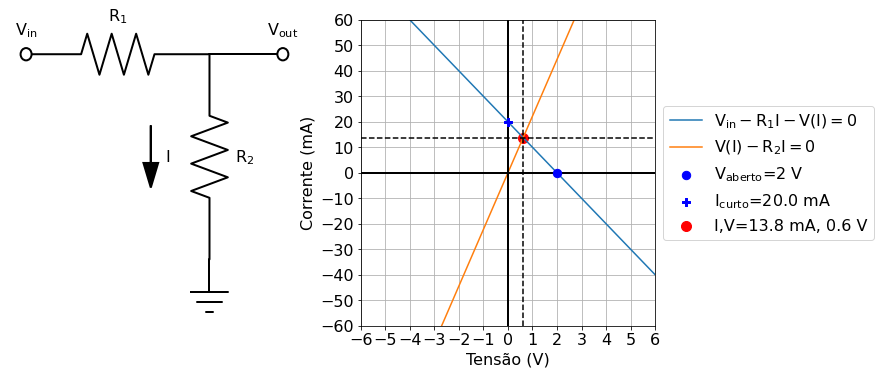

In [21]:
plot_load_lines(Vin=2,R1=(100),R2=(45))

## Transistor

In [5]:
def draw_transistor(unit_size, **kwargs):
    d = schem.Drawing(unit=unit_size,**kwargs)
    VB = d.add(e.DOT_OPEN, label='$V_{BB}$')
    RB = d.add(e.RES, d='right',label='$R_{B}$')
    bjt = d.add(e.BJT_NPN_C, d='right')
    #----
    Rc = d.add(e.RES, d='up', xy=bjt.collector, label='$R_C$')
    Vcc = d.add(e.DOT_OPEN, label='$V_{CC}$')
    #RE = d.add(e.RES, d='down', xy=bjt.emitter, label='$R_E$')
    gnd = d.add(e.GND,xy=bjt.emitter)
    return d
def plot_load_lines_transistor(Vcc=10,Rc=100,Vbb=1,Rb=1000):
    def Ib(Vbe,Ies=3*1e-14):
        β = 39.6 #[1/V]
        return Ies*(np.exp(β*Vbe-1))
    def Ic(Vce,Ies=300*1e-14, VEA = 200):
        β = 39.6 #[1/V]
        #VEA = 40 # Early Voltage 
        βr = 0.0001
        αr = βr/(1+βr)
        Vbc = Vbe - Vce
        return Ies*( np.exp(β*Vbe-1)*(1+(Vbe-Vbc)/VEA) - 1/αr*(np.exp(β*Vbc)-1))
    def Vdiodo(I,Is=1e-13):
        β = 39.6 #[1/V]
        return 1/β*np.log(1+I/Is)
    def KVL(V,Vin,R):
        return Vin-R*Ic(V)-V
    def KVLb(V,Vin,R):
        return Vin-R*Ib(V)-V
    def Vdiodo(Vin,V0,R):
        return optimize.brentq(KVL, -1.1*V0, 1.1*V0, args = (Vin,R))
    def Vdiodob(Vin,V0,R):
        return optimize.brentq(KVLb, -1.1*V0, 1.1*V0, args = (Vin,R))
    #return fixed_point(lambda x: Vin-R*Idiodo(x)-x,0.6,args=(1.0,100))
    npt=50
    Vin = Vcc
    Vb0 = Vbb
    #---
    fig_size = (18,6)
    fig,ax = plt.subplots(1,3,figsize=fig_size)
    #------------------
    ax0 = ax[0]
    draw_transistor(2.5).draw(ax=ax0)
    ax0.set_aspect('equal')
    #DivTensao([e.RES,'R'],[e.DIODE,'D'],fonte = [False,e.SOURCE_V]).draw(ax=ax0)
    ax0.axes.get_xaxis().set_visible(False)
    ax0.axes.get_yaxis().set_visible(False)
    ax0.set_frame_on(False)
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    ax0.get_figure().set_size_inches(fig_size[0]*0.7,fig_size[1])
    
    #------------------
    #BASE
    Vin_min, Vin_max = 0,2 # [V]
    I_min, I_max = 0,1500e-6 # [μA]
    I=np.linspace(I_min,I_max,npt)
    V = np.linspace(0,1,npt)
    Vlhs = Vb0-Rb*I # equação LHS
    ax0 = ax[1]
    ax0.plot(Vlhs,I*1e6,label = r'$V_{BB}-R_B I_B-V_{BE}(I_B)=0$')
    ax0.plot(V, Ib(V)*1e6, c='r',lw=2, label = r'$I_B(V_{BE})$',zorder=4)
    #solução para corrente e tensão
    Vd = Vdiodob(Vb0,Vb0,Rb) # equação RHS
    Id = Ib(Vd)
    ax0.axhline(1e6*Id, c='k', ls = '--',zorder=0)
    ax0.axvline(Vd, c='k', ls = '--',zorder=0)
    lab =  r'$I_B$,$V_{BE}$'+'={:2.0f} μA, {:2.0f} mV'.format(1e6*Id,1e3*Vd)
    ax0.scatter(Vd,1e6*Id, c='r', marker='o', s=100, label=lab)
    #---
    #lab = '$V_{aberto}$'+'={} V'.format(Vb0)
    ax0.scatter(Vb0,0, color='b', marker='o', s=70,zorder=3)
    #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e6*Vin/Rb)
    ax0.scatter(0,Vb0/Rb*1e6, color='b', marker='P', s=70,zorder=3)
    #---
    #eixos x-y
    ax0.axhline(0, color='k', linestyle = '-',lw=2)
    ax0.axvline(0, color='k', linestyle = '-',lw=2)
    #-----------------------
    ax0.set_xlabel('Tensão, $V_{BE}$ (V)')
    ax0.set_ylabel('Corrente, $I_B$ (μA)')
    ax0.set_xlim([Vin_min,Vin_max])
    ax0.set_ylim(np.array([I_min,I_max])*1e6)
    ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
    ax0.grid(True,which='both')
    #------------------
    #COLETOR_EMISSOR
    Vbe = Vd # from previous
    #limites dos eixos
    Vin_min, Vin_max = -1,10 # [V]
    I_min, I_max = -1,100 # [mA]
    #-------------
    V = np.linspace(0,10,npt)
    #I = Idiodo(V)  # equação diodo
    I=np.linspace(I_min,I_max,npt)
    #----------------------
    Vlhs = Vin-Rc*I # equação LHS
    #Vlhs = Vin-R*Id # equação LHS
    #Vrhs = Vdiodo(Vin,Vin,R) # equação RHS
    
    
    ax0 = ax[2]
    ax0.plot(Vlhs,I*1e3, label = r'$V_{CC}-R_C I_C-V_{CE}(I_C)=0$')
    ax0.plot(V, Ic(V)*1e3, c='r',lw=2,label = r'$I_C(V_{CE})$',zorder=4)
    #---
    #eixos x-y
    ax0.axhline(0, color='k', linestyle = '-',lw=2)
    ax0.axvline(0, color='k', linestyle = '-',lw=2)
    #---
    #lab = '$V_{aberto}$'+'={} V'.format(Vin)
    ax0.scatter(Vin,0, color='b', marker='o', s=70,zorder=3)
    #lab = '$I_{curto}$'+'={:2.1f} mA'.format(1e3*Vin/Rc)
    ax0.scatter(0,Vin/Rc*1e3, color='b', marker='P', s=70,zorder=3)
    #solução para corrente e tensão
    Vd = Vdiodo(Vin,Vin,Rc) # equação RHS
    Id = Ic(Vd)
    ax0.axhline(1e3*Id, c='k', ls = '--',zorder=0)
    ax0.axvline(Vd, c='k', ls = '--',zorder=0)
    lab = r'$I_C$,$V_{CE}$'+'={:2.0f} mA, {:2.0f} V'.format(1e3*Id,Vd)
    ax0.scatter(Vd,1e3*Id, c='r', marker='o', s=100, label=lab)
    #-----------------------
    ax0.set_xlabel('Tensão, $V_{CE}$ (V)')
    ax0.set_ylabel('Corrente, $I_C$ (mA)')
    ax0.set_xlim([Vin_min,Vin_max])
    ax0.set_ylim([I_min,I_max])
    ax0.legend(loc = 'lower center',bbox_to_anchor=[0.5,1.0])
    ax0.grid(True,which='both')
    ax0.xaxis.set_major_locator(plticker.MultipleLocator(2))
    ax0.yaxis.set_major_locator(plticker.MultipleLocator(10)) 
    
    #ax0.xaxis.set_major_locator(plticker.MultipleLocator(1))
    #ax0.yaxis.set_major_locator(plticker.MultipleLocator(2)) 
    plt.tight_layout()
    return

In [51]:
# interact(plot_load_lines_transistor,Vcc=(1,10,1),Rc=(1,300),Vbb=(0.5,1.5,0.1),Rb=(1e2,5e3,1e2))

The function above looks a bit complicated, but the idea is the same as in the transistor. The result is that it produces the following plots:

### Active region ($V_{BE}>0.6$ and $V_{CE}>V_{BE}V$)

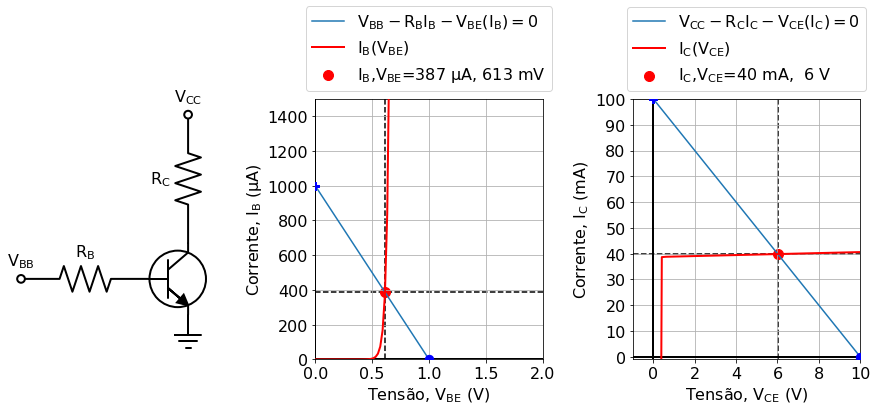

In [79]:
plot_load_lines_transistor(Vcc=10,Rc=100,Vbb=1,Rb=1000);

### Saturated region ($V_{BE}>0.6$ and $V_{CE}<V_{BE}$)

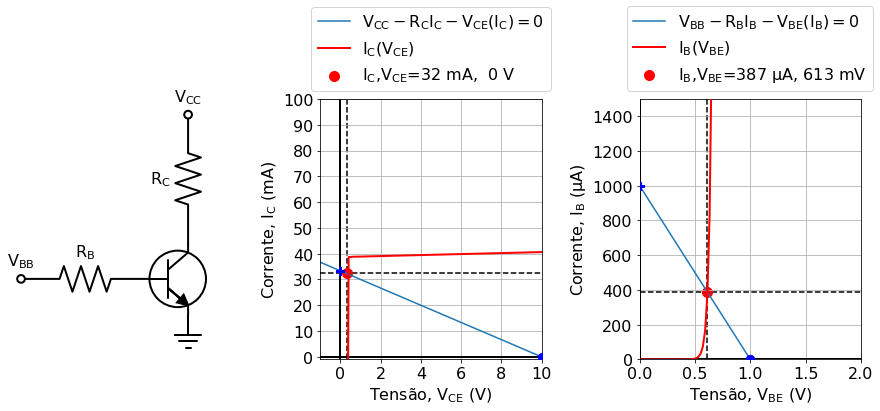

In [63]:
plot_load_lines_transistor(Vcc=10,Rc=300,Vbb=1,Rb=1000)

### Off region ($V_{BE}<0.6$), in this case the transistor  will be off regardless of  $V_{CE}$)

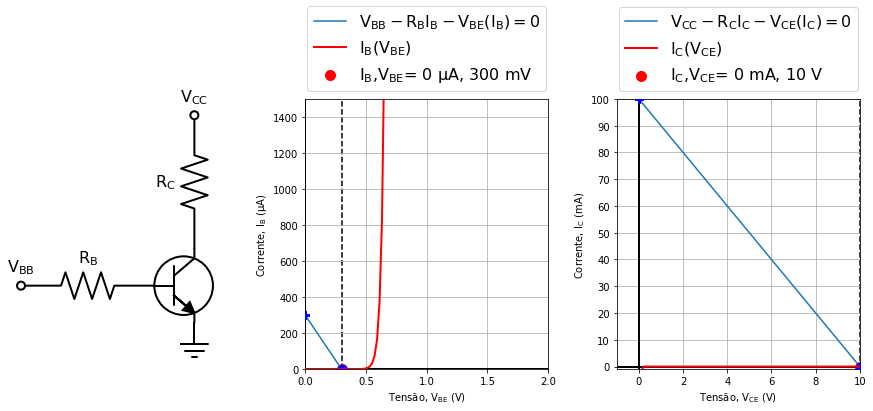

In [6]:
plot_load_lines_transistor(Vcc=10,Rc=100,Vbb=0.3,Rb=1000)

Interactive code code below for an interactive

In [9]:
interact(plot_load_lines_transistor,Vcc=(1,10,1),Rc=(1,300),Vbb=(0.2,2.0,0.1),Rb=(1e2,5e3,1e2))

interactive(children=(IntSlider(value=10, description='Vcc', max=10, min=1), IntSlider(value=100, description=…

<function __main__.plot_load_lines_transistor(Vcc=10, Rc=100, Vbb=1, Rb=1000)>

In [77]:
# #generate animation
# vbb_vec = np.linspace(0.2,1.2,30);
# vbb_vec = np.concatenate([vbb_vec,np.flip(vbb_vec)])
# for ii,vbb in enumerate(vbb_vec):
#     fig = plot_load_lines_transistor(Vcc=10,Rc=100,Vbb=vbb,Rb=1000)
#     fig.savefig('transistor2_ac_{:03}.png'.format(ii))
#     plt.close()